# Query 6
0. Exact result
1. Stratified sampling
2. Weighted KDE
3. Curse of Dimensionality

In [ ]:
select
	sum(l_extendedprice * l_discount) as revenue
from
	lineitem
where
	l_shipdate >= date ':1'
	and l_shipdate < date ':1' + interval '1' year
	and l_discount between :2 - 0.01 and :2 + 0.01
	and l_quantity < :3;

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

from collections import Counter

import scipy
from scipy.stats import gaussian_kde
from scipy import integrate

import timeit
import pickle
from datetime import date, timedelta
import sys
import scipy.stats as st
from random import random

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.functions import col

from pyspark import broadcast
# To avoid OverflowError: cannot serialize a string larger than 4GiB
def broadcast_dump(self, value, f):
    pickle.dump(value, f, 4)  # was 2, 4 is first protocol supporting >4GB
    f.close()
    return f.name
broadcast.Broadcast.dump = broadcast_dump

conf = pyspark.SparkConf().setMaster("local[16]").setAll([
                                   ('spark.executor.memory', '4g'),  # find
                                   ('spark.driver.memory','10g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import stratified_sampling

In [6]:
lineitem = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/lineitem.parquet").limit(50000)

### Helper Functions

In [7]:
def calculate_error(Q1_approx, Q1_exact):
    df_2 = Q1_approx.toPandas().astype(float)
    df_1 = Q1_exact.toPandas().astype(float)
    return abs(df_2 - df_1) * 100 / df_1

def calculate_size_of(obj):
    p = pickle.dumps(obj)
    size = sys.getsizeof(p)
    print('The size of the object in MB: ', size / 2 ** 20)
    return size

In [8]:
CONSTRUCTION_TIME = [0] * 2
EXECUTION_TIME = [0] * 2
SPACE = [0] * 2
ERROR = [0] * 2

In [9]:
DATE = date(1996, 2, 1)
DISCOUNT = 0.1
QUANTITY = 50
QCS = ['l_shipdate', 'l_discount', 'l_quantity']

# 0. Exact Result

In [10]:
def compute_exact_result(df, the_date, the_disc, the_quantity):
    return df.where( (the_date <= f.col("l_shipdate")) & (f.col("l_shipdate") < the_date + timedelta(days = 365)))\
            .where( (the_disc - 0.01 <= f.col("l_discount")) & (f.col("l_discount") <= the_disc + 0.01))\
            .where( f.col('l_quantity') < the_quantity)\
            .agg(f.sum(f.col('l_extendedprice') * f.col('l_discount')).alias('revenue'))
    
exact_result = compute_exact_result(lineitem, DATE, DISCOUNT, QUANTITY).cache()
exact_result.show()

+------------+
|     revenue|
+------------+
|2398177.6890|
+------------+



# 1. Stratified Sampling
## 1.1. Construction

In [17]:
start = timeit.default_timer()
sample_df = stratified_sampling.generate_stratified_sample(lineitem, QCS, 0.01, 0.99).cache(); sample_df.count()
count_df = lineitem.groupby(QCS).count()
stop = timeit.default_timer()
CONSTRUCTION_TIME[0] = stop - start
print('Construction time is ', stop - start)

Construction time is  3.4271335519999866


### Space

In [18]:
SPACE[0] = calculate_size_of(sample_df.toPandas()) + calculate_size_of(count_df.toPandas())

The size of the object in MB:  1.078598976135254
The size of the object in MB:  0.26728343963623047


## 1.2. Execution


In [19]:
def compute_approximate_result(sample_df, count_df, the_date, the_disc, the_quantity):
    count_df_ = count_df.where( (the_date <= f.col("l_shipdate")) & (f.col("l_shipdate") < the_date + timedelta(days = 365)))\
            .where( (the_disc - 0.01 <= f.col("l_discount")) & (f.col("l_discount") <= the_disc + 0.01))\
            .where( f.col('l_quantity') < the_quantity).agg(f.sum('count'))\
            .withColumn('id', f.monotonically_increasing_id())
    
    sample_df_avg = sample_df.where( (the_date <= f.col("l_shipdate")) & (f.col("l_shipdate") < the_date + timedelta(days = 365)))\
            .where( (the_disc - 0.01 <= f.col("l_discount")) & (f.col("l_discount") <= the_disc + 0.01))\
            .where( f.col('l_quantity') < the_quantity)\
            .agg(f.avg(f.col('l_extendedprice') * f.col('l_discount')).alias('revenue'))\
            .withColumn('id', f.monotonically_increasing_id())
    
    return sample_df_avg.join(count_df_, 'id')\
                .select( (f.col('sum(count)') * f.col('revenue')).alias('revenue') )

### Execution Time

In [23]:
start = timeit.default_timer()
sample_result = compute_approximate_result(sample_df, count_df, DATE, DISCOUNT, QUANTITY).cache(); sample_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[0] = stop - start
print('Execution time is ', stop - start)

+-------------+
|      revenue|
+-------------+
|127652.245005|
+-------------+

Execution time is  0.13169842499996776


### Error

In [24]:
sample_error = calculate_error(sample_result, exact_result)
sample_error

,revenue
0,3.916899e-09


In [25]:
ERROR[0] = (sample_error.mean(), sample_error.std())

# 2. Weighted-KDE
## 2.1. Construction

In [11]:
lineitem_clean = lineitem.withColumn('l_shipdate', f.to_date('l_shipdate', 'yyyy-MM-dd'))\
                            .withColumn('l_extendedprice', f.col('l_extendedprice').cast('float'))\
                            .withColumn('l_discount', f.col('l_discount').cast('float'))\
                            .withColumn('l_quantity', f.col('l_quantity').cast('float'))

In [12]:
transform, i_transform = {}, {}
normalize = {}

START_DATE = lineitem_clean.select(f.min('l_shipdate')).first()[0]
END_DATE = lineitem_clean.select(f.max('l_shipdate')).first()[0]
normalize['date'] = (START_DATE, END_DATE)
def lambda_normalize_date(x):
    transformed_date = -1 + 2 * (x - normalize['date'][0]).days / (normalize['date'][1] - normalize['date'][0]).days
    if transformed_date < -1: return -1
    elif transformed_date > 1: return 1
    else: return transformed_date
transform['date'] = lambda_normalize_date

MIN_QUANTITY = lineitem_clean.select(f.min('l_quantity')).first()[0]
MAX_QUANTITY = lineitem_clean.select(f.max('l_quantity')).first()[0]
normalize['quantity'] = (MIN_QUANTITY, MAX_QUANTITY)
transform['quantity'] = lambda x: -1 + 2 * (x - normalize['quantity'][0])/(normalize['quantity'][1] - normalize['quantity'][0])
i_transform['quantity'] = lambda x: 0.5 * (x + 1) * (normalize['quantity'][1] - normalize['quantity'][0]) + normalize['quantity'][0]

MIN_DISC = lineitem_clean.select(f.min('l_discount')).first()[0]
MAX_DISC = lineitem_clean.select(f.max('l_discount')).first()[0]
normalize['disc'] = (MIN_DISC, MAX_DISC)
transform['disc'] = lambda x: -1 + 2 * (x - normalize['disc'][0])/(normalize['disc'][1] - normalize['disc'][0])
i_transform['disc'] = lambda x: 0.5 * (x + 1) * (normalize['disc'][1] - normalize['disc'][0]) + normalize['disc'][0]

### Construction

In [15]:
def kde_based_method_construction(lineitem_clean, bw='scott'):
    X = lineitem_clean.groupby('l_shipdate', 'l_discount', 'l_quantity')\
            .agg(f.sum(f.col('l_extendedprice') * f.col('l_discount')).alias('revenue')).rdd.collect()
    
    X_shipdate = [transform['date'](row['l_shipdate']) for row in X]
    X_discount = [transform['disc'](row['l_discount']) for row in X]
    X_quantity = [transform['quantity'](row['l_quantity']) for row in X]
    X_revenue = [row['revenue'] for row in X]
    
    hashMap_kde = dict()
    hashMap_kde['revenue'] = gaussian_kde( [X_shipdate, X_discount, X_quantity], bw_method=bw, weights=X_revenue)
    hashMap_kde['revenue_sum'] = np.sum(X_revenue)
    
    return hashMap_kde

In [16]:
start = timeit.default_timer()
hashMap_kde = kde_based_method_construction(lineitem_clean)
stop = timeit.default_timer()
CONSTRUCTION_TIME[1] = stop - start
print(stop - start)

1.3442616520000001


### Space

In [17]:
SPACE[1] = calculate_size_of(hashMap_kde)

The size of the object in MB:  1.4980688095092773


## Testing

In [33]:
def kde_based_method_testing(hashMap_kde, the_date, the_disc, the_quantity, bw='scott'):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    l_date, r_date = transform['date'](the_date), transform['date'](the_date + timedelta(days = 365))
    l_disc, r_disc = transform['disc'](the_disc - 0.01), transform['disc'](the_disc + 0.01)
    l_qty, r_qty =  -np.inf, transform['quantity'](the_quantity)
    
    res = hashMap_kde['revenue'].integrate_box([l_date, l_disc, l_qty], [r_date, r_disc, r_qty]) * hashMap_kde['revenue_sum'] 
    
    return spark.createDataFrame([float(res)], "float").toDF("revenue")


### Execution

In [34]:
start = timeit.default_timer()
weighed_kde_result = kde_based_method_testing(hashMap_kde, DATE, DISCOUNT, QUANTITY).cache(); weighed_kde_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[1] = stop - start
print('Execution time is', stop - start)

+---------+
|  revenue|
+---------+
|3347749.0|
+---------+

Execution time is 5.37860697900004


/Users/futongliu/opt/anaconda3/envs/ada/lib/python3.7/site-packages/scipy/stats/kde.py:385: UserWarning: An integral in mvn.mvnun requires more points than 3000
  warnings.warn(msg)


### Error

In [20]:
weighted_kde_error = calculate_error(weighed_kde_result, exact_result)
ERROR[1] = (weighted_kde_error.mean(), weighted_kde_error.mean())

In [21]:
weighted_kde_error

,revenue
0,39.595536


# 3. How does the number of dimensions influence the performance

In [22]:
def kde_based_method_1D(hashMap_kde, the_quantity):
    exact = lineitem.where( f.col('l_quantity') < the_quantity)\
            .agg(f.sum(f.col('l_extendedprice') * f.col('l_discount')).alias('revenue')).first()[0]
    exact = float(exact)
    
    r_qty = transform['quantity'](the_quantity)
    res = hashMap_kde['revenue'].integrate_box([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, r_qty]) * hashMap_kde['revenue_sum'] 
    
    return (exact - res) / exact

In [23]:
def kde_based_method_2D(hashMap_kde, the_date, the_quantity, bw=.01):
    exact = lineitem.where( f.col('l_quantity') < the_quantity)\
            .where( (the_date <= f.col("l_shipdate")) & (f.col("l_shipdate") < the_date + timedelta(days = 365)))\
            .agg(f.sum(f.col('l_extendedprice') * f.col('l_discount')).alias('revenue')).first()[0]
    exact = float(exact)
    
    l_date, r_date = transform['date'](the_date), transform['date'](the_date + timedelta(days = 365))
    l_qty, r_qty =  -np.inf, transform['quantity'](the_quantity)
    res = hashMap_kde['revenue'].integrate_box([l_date, -np.inf, l_qty], [r_date, np.inf, r_qty]) * hashMap_kde['revenue_sum'] 
    
    return (exact - res) / exact

In [24]:
def kde_based_method_3D(hashMap_kde, the_date, the_discount, the_quantity, bw=.01):
    exact = compute_exact_result(lineitem, the_date, the_discount, the_quantity).first()[0]
    exact = float(exact)
    
    res = kde_based_method_testing(hashMap_kde, the_date, the_discount, the_quantity).first()[0]; #kde_result.show()

    return (exact - res) / exact

In [25]:
def effect_of_dimenionality(quantity_range):
    error_bank = []
    for q in quantity_range:
        error_1d = kde_based_method_1D(hashMap_kde, q)
        error_2d = kde_based_method_2D(hashMap_kde, DATE, q)
        error_3d = kde_based_method_3D(hashMap_kde, DATE, DISCOUNT, q)
        error_bank.append([error_1d, error_2d, error_3d])
    return error_bank

In [26]:
quantity_range = np.linspace(2, 50, 10)
error_bank = effect_of_dimenionality(quantity_range)
error_bank

[[-4.37481689171183, -4.477947980542624, -7.791698960713419],
 [-0.09689302629493052, -0.13412742643282838, -0.8613893546470632],
 [-0.07276033531313998, -0.07583503926472118, -0.5796388505322264],
 [-0.0894254415285541, -0.09945921541498608, -0.6861227465018283],
 [0.00158062077626182, -0.00690933728064546, -0.44919277119564793],
 [-0.02264953401218724, -0.009664142192562052, -0.3778080151802254],
 [-0.03707197137384898, -0.02756644763399232, -0.37155417938768526],
 [0.005545727988380883, 0.01308217705797555, -0.3424746973702583],
 [-0.012003378026759152, -0.010269714686144703, -0.4155787704542602],
 [0.014443362926561332, 0.011834236144471072, -0.395955360336938]]

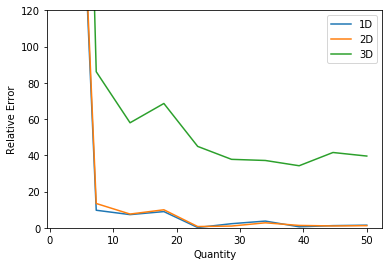

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(quantity_range, np.abs(error_bank)[:,0] * 100, label='1D')
plt.plot(quantity_range, np.abs(error_bank)[:,1] * 100, label='2D')
plt.plot(quantity_range, np.abs(error_bank)[:,2] * 100, label='3D')
plt.legend()
plt.xlabel('Quantity')
plt.ylabel('Relative Error')
plt.ylim(0,120)
plt.savefig('./figs/Q6_curse.png')

Distributino of column "l_discount"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dce7150>]],
      dtype=object)

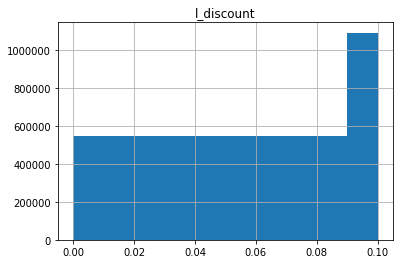

In [151]:
spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/lineitem.parquet").select('l_discount').toPandas().astype(float).hist()